# LETOR with Microsoft `lightgbm` implementation of `LambdaMART`

This notebook shows how to implement `LambdaMART` with the efficient Microsoft implementation of `xgboost`, `lightgbm`. Here we use this algo first with toy data and next, we translate to the stock ranking problem with monthly rebalancing.

In [1]:
# Importing important libraries
import optuna
import joblib
import numpy as np
import pandas as pd
import lightgbm as lightgbm
import optuna.integration.lightgbm as optuna_lgb

from collections import OrderedDict
from sklearn.model_selection import ParameterGrid

## Toy Ratings

See [Medium Article](https://medium.datadriveninvestor.com/a-practical-guide-to-lambdamart-in-lightgbm-f16a57864f6):

1. **Loading the data** (missing dummy data file, can be easily regenerated with random data)
2. **Splitting the data into train and test** (Custom splitting based on `qid`)
3. **Preparing the data for `LightGBM`**
4. **Training the `LightGBM` `LambdaMART` Model**
5. **Feature Importance**

## Stock Ratings (Pairwise)

### 1. Loading the Data

In [2]:
stock_features = pd.read_csv(
    "data/config/20220831_last_enhanced_dataset_monthly.csv",
    parse_dates=["Date"]
).iloc[:,:-1]
stock_features

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821
...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217


In [3]:
stock_isharpe_scores = pd.read_csv(
    "data/config/20220831_lagged_isharpe_scores_monthly.csv",
    usecols=["Date","symbols","ISR12M"],
    parse_dates=["Date"]
)

In [4]:
stock_isharpe_scores

,Date,symbols,ISR12M
0,2007-09-28,A,11.0
1,2007-09-28,AA,15.0
2,2007-09-28,AAPL,19.0
3,2007-09-28,ABC,9.0
4,2007-09-28,ABT,13.0
...,...,...,...
83946,2022-07-29,XRX,5.0
83947,2022-07-29,Y,18.0
83948,2022-07-29,YUM,8.0
83949,2022-07-29,ZBH,4.0


Merge features with relevances

In [5]:
df = pd.merge(    
        stock_features,
        stock_isharpe_scores,
    on=["Date","symbols"],
    how="inner"
).rename(columns=
    {
        "ISR12M_x": "ISR12M",
        "ISR12M_y": "relevance"
    }
)
df = df.astype({"relevance": "int8"})

In [6]:
df

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168,14
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691,15
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120,19
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703,10
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500,5
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267,18
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148,8
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217,4


In [7]:
# Dumping for Archive
df.to_csv(
    "data/config/20220831_letor_stock_monthly_relevances_minimal.csv",
    index=False
)

### 2. Splitting the data intro train and test

In [15]:
df

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168,14
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691,15
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120,19
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703,10
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500,5
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267,18
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148,8
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217,4


In [8]:
train = df[df["Date"]<"2019"]
test = df[df["Date"]>="2019"]

In [9]:
train.shape[0]/df.shape[0]

0.7584269662921348

In [10]:
train.tail(5)

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
63310,2018-12-31,XRX,-0.258182,-0.158309,-0.300977,-1.272273,-0.551624,-0.741578,-0.446705,-0.092341,-0.104940,0.437453,8
63311,2018-12-31,Y,-0.044764,0.084091,0.062682,-0.384201,0.510344,0.268990,-0.036521,0.920273,0.464947,0.230673,13
63312,2018-12-31,YUM,0.015310,0.185095,0.131370,0.131485,1.124066,0.564129,0.375977,2.005676,0.727172,0.230542,17
63313,2018-12-31,ZBH,-0.209214,-0.065355,-0.140732,-1.449341,-0.320143,-0.487463,-0.256849,-0.026257,-0.038032,0.290759,5
63314,2018-12-31,ZION,-0.182678,-0.217697,-0.190665,-1.264173,-1.065267,-0.659723,-0.219707,-0.110371,-0.043985,0.278573,7


In [11]:
print(f"No of unique monthly rebalance dates in train : {train['Date'].nunique()}")
print(f"No of unique monthly rebalance dates in test : {test['Date'].nunique()}")
print(f"Fraction : {100*train['Date'].nunique()/df['Date'].nunique():.1f}")

No of unique monthly rebalance dates in train : 135
No of unique monthly rebalance dates in test : 43
Fraction : 75.8


In [12]:
df.groupby("Date").agg([np.max, np.min, np.median])["relevance"]

/tmp/ipykernel_60173/2402063399.py:1: FutureWarning: ['symbols'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Date").agg([np.max, np.min, np.median])["relevance"]


,amax,amin,median
Date,,,
2007-10-31,19,0,9.0
2007-11-30,19,0,9.0
2007-12-31,19,0,9.0
2008-01-31,19,0,9.0
2008-02-29,19,0,9.0
...,...,...,...
2022-03-31,19,0,9.0
2022-04-29,19,0,9.0
2022-05-31,19,0,9.0


### 3. Preparing the data for `LightGBM`

Before we move on to train the `LightGBM` `LambdaMART` on our stock data, we would need to split the data into the features and the relevance label which are essentially called `(X_train ,y_train)` for training set and `(X_test, y_test)` for test set.

In addition to this, we would also need the group , both for train and test set (evaluation set). group is essentially a `numpy` array which basically associates the queries to the features during training.

We have an static 469-stock dataset with group = [469, 469, ...], that means that you have 135+43 groups, where the first 469 records are in the first rebalance date, records 470-... are in the second rebalance month, etc.

In [13]:
# Creating a numpy array which contains group
qids_train = train.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would train our model 
X_train = train.drop(["Date", "relevance", "symbols"], axis = 1)
# Relevance label for train
y_train = train[['relevance']].astype(int)

# Creating a numpy array which contains eval_group
qids_test = test.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would validate our model
X_test = test.drop(["Date", "relevance", "symbols"], axis = 1)
# Relevance label for test
y_test = test[['relevance']].astype(int)

In [14]:
X_train

,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M
0,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168
1,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691
2,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120
3,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703
4,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821
...,...,...,...,...,...,...,...,...,...,...
63310,-0.258182,-0.158309,-0.300977,-1.272273,-0.551624,-0.741578,-0.446705,-0.092341,-0.104940,0.437453
63311,-0.044764,0.084091,0.062682,-0.384201,0.510344,0.268990,-0.036521,0.920273,0.464947,0.230673
63312,0.015310,0.185095,0.131370,0.131485,1.124066,0.564129,0.375977,2.005676,0.727172,0.230542
63313,-0.209214,-0.065355,-0.140732,-1.449341,-0.320143,-0.487463,-0.256849,-0.026257,-0.038032,0.290759


In [15]:
y_train

,relevance
0,14
1,15
2,19
3,10
4,17
...,...
63310,8
63311,13
63312,17
63313,5


In [24]:
len(qids_train), len(qids_test)

(135, 43)

### 4. Training the `LightGBM` `LambdaMART` Model


While most of the parameters are very well documented on the LightGBM’s official website, I’ll discuss a few here which aren’t.

* First thing first, the only objective which is available for Ranking in LightGBM is `lambdarank` and LambdaMART is the _boosted tree version_ of _LambdaRank_. So, In essence `lambdarank` objective along with `gbdt` boosting_type is what LambdaMART is.

Second, Ranking objectives in LightGBM use `label_gain_` to store the gain of each label value. By default, `label_gain_[i] = (1 << i) - 1`. So the default label gain only works with a _maximum label value **31**_. So, in case your label value exceeds **31** , you will have to specify your customized label_gain .

Third, in the fit method, while setting the parameters eval_set and eval_group , if you wish to evaluate your model only on test set, then you will only have to pass (X_test, y_test) and qids_test to eval_set and eval_group parameters respectively.

In [16]:
# Creating the ranker object
ranker = lightgbm.LGBMRanker(
    n_estimators=15000,
    random_state=42,
    num_leaves=41,
    learning_rate=0.002,
    max_bin =20,
    subsample_for_bin=20000,
    colsample_bytree=0.7,
    n_jobs=6
)                    

In [17]:
qids_train

array([469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469,
       469, 469, 469, 469, 469])

In [18]:
# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      verbose=100,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[25] # The size of ventile-based portfolios
)

/home/hcf/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's ndcg@25: 0.745613	valid_1's ndcg@25: 0.723192
[200]	training's ndcg@25: 0.747273	valid_1's ndcg@25: 0.714567
[300]	training's ndcg@25: 0.752882	valid_1's ndcg@25: 0.7118
[400]	training's ndcg@25: 0.757329	valid_1's ndcg@25: 0.714278
[500]	training's ndcg@25: 0.76018	valid_1's ndcg@25: 0.715359
[600]	training's ndcg@25: 0.763465	valid_1's ndcg@25: 0.717526
[700]	training's ndcg@25: 0.766055	valid_1's ndcg@25: 0.719005
[800]	training's ndcg@25: 0.77093	valid_1's ndcg@25: 0.719157
[900]	training's ndcg@25: 0.773724	valid_1's ndcg@25: 0.722049
[1000]	training's ndcg@25: 0.777255	valid_1's ndcg@25: 0.722509
[1100]	training's ndcg@25: 0.778956	valid_1's ndcg@25: 0.727104
[1200]	training's ndcg@25: 0.780816	valid_1's ndcg@25: 0.728276
[1300]	training's ndcg@25: 0.784417	valid_1's ndcg@25: 0.730288
[1400]	training's ndcg@25: 0.787252	valid_1's ndcg@25: 0.733273
[1500]	training's ndcg@25: 0.789916	valid_1's ndcg@25: 0.735552
[1600]	training's ndcg@25: 0.792796	valid_1's ndcg@25

LGBMRanker(colsample_bytree=0.7, learning_rate=0.002, max_bin=20,
           n_estimators=15000, n_jobs=6, num_leaves=41, random_state=42,
           subsample_for_bin=20000)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

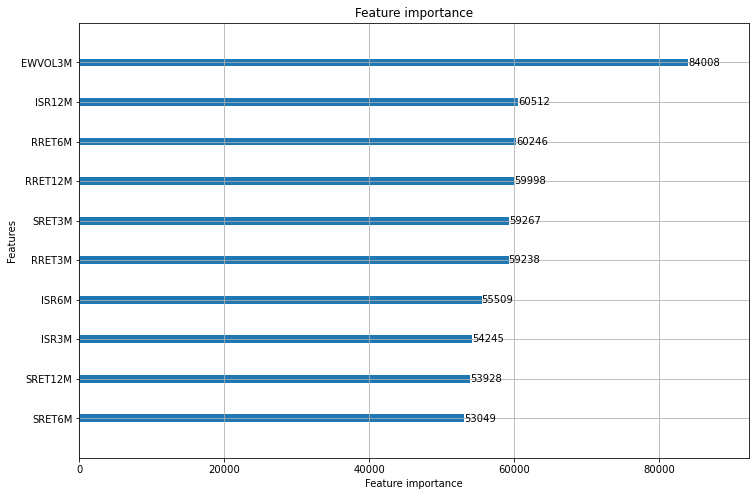

In [19]:
lightgbm.plot_importance(ranker, figsize = (12,8))

In [20]:
predictions = pd.DataFrame(test[["Date","symbols"]])

In [21]:

predictions["gain"] = ranker.predict(X_test)

In [24]:
predictions.groupby("Date")["gain"].nunique()

Date
2019-01-31    466
2019-02-28    469
2019-03-29    468
2019-04-30    468
2019-05-31    461
2019-06-28    468
2019-07-31    469
2019-08-30    461
2019-09-30    465
2019-10-31    467
2019-11-29    469
2019-12-31    469
2020-01-31    468
2020-02-28    464
2020-03-31    307
2020-04-30    354
2020-05-29    401
2020-06-30    456
2020-07-31    460
2020-08-31    468
2020-09-30    466
2020-10-30    468
2020-11-30    468
2020-12-31    468
2021-01-29    468
2021-02-26    466
2021-03-31    453
2021-04-30    443
2021-05-31    465
2021-06-30    468
2021-07-30    469
2021-08-31    467
2021-09-30    469
2021-10-29    468
2021-11-30    468
2021-12-31    469
2022-01-31    469
2022-02-28    468
2022-03-31    467
2022-04-29    463
2022-05-31    463
2022-06-30    431
2022-07-29    462
Name: gain, dtype: int64

In [23]:
predictions

,Date,symbols,gain
63315,2019-01-31,A,-6.140640
63316,2019-01-31,AA,-14.284013
63317,2019-01-31,AAPL,-7.975015
63318,2019-01-31,ABC,-11.424599
63319,2019-01-31,ABT,-2.960122
...,...,...,...
83477,2022-07-29,XRX,-12.596286
83478,2022-07-29,Y,-3.279982
83479,2022-07-29,YUM,-11.301702
83480,2022-07-29,ZBH,-13.566651


In [25]:
score_predictions = pd.pivot(
    predictions,
    index="Date",
    columns="symbols",
    values="gain"
).rank(axis=1).apply(
    pd.cut, bins=20, labels=False, axis=1
).melt(    
    var_name="symbols",
    value_name="relevance_predicted",
    ignore_index=False
).sort_values(by=["Date","symbols"])

In [35]:
score_predictions

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,15,0,12,8,17,17,16,15,14,17,...,11,5,19,6,1,8,14,18,6,7
2019-02-28,15,1,8,4,18,17,14,14,9,18,...,14,1,19,12,0,13,11,17,10,6
2019-03-29,15,0,11,6,18,17,13,14,10,18,...,14,3,18,13,10,14,10,17,14,3
2019-04-30,15,0,10,2,17,18,13,17,8,17,...,14,1,18,9,10,15,16,19,9,4
2019-05-31,13,0,9,8,17,16,13,11,5,16,...,4,2,19,6,17,15,16,19,12,4
2019-06-28,15,0,11,9,19,16,14,15,6,17,...,2,4,19,8,17,18,15,19,11,4
2019-07-31,9,0,12,11,18,15,14,15,4,18,...,1,4,19,8,14,15,13,19,12,5
2019-08-30,11,1,8,9,16,12,13,14,7,15,...,1,4,19,7,18,12,16,19,14,4
2019-09-30,10,0,11,7,15,11,11,14,5,12,...,1,8,19,4,19,13,18,18,12,6


In [51]:
mask_best = (score_predictions==19).shift(1)


In [53]:
mask_best.iloc[0].sum()

0

In [38]:
import pickle

with open("data/config/20220831_returns_scores.pkl","rb") as f:
    return_data = pickle.load(f)

return_data.keys()


dict_keys(['raw_returns', 'sma_vols', 'ewma_vols', 'score'])

In [39]:
return_data["raw_returns"].keys()

dict_keys(['daily', 'weekly', 'monthly'])

In [40]:
port_rets_monthly = return_data["raw_returns"]["monthly"]

In [41]:
port_rets_monthly

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-31,0.101485,0.083089,0.043786,-0.008851,0.033784,0.085266,0.011826,0.051021,0.096360,0.024427,...,0.063013,0.059834,0.065146,-0.083851,0.068867,0.083402,0.046690,0.160207,0.090922,-0.001202
2006-11-30,-0.050771,0.130488,-0.024598,-0.017891,0.049935,0.026872,-0.085770,-0.024474,0.120544,0.011276,...,-0.003142,-0.059611,0.003110,-0.096045,-0.025785,0.063396,-0.000430,-0.105313,0.062758,0.000512
2006-12-29,0.094535,-0.074406,-0.022396,0.043935,0.023904,0.010762,-0.089459,0.026060,-0.017484,-0.006397,...,0.029098,0.030989,0.096796,0.040222,0.043959,-0.025794,0.021730,-0.035917,0.004777,0.022209
2007-01-31,-0.081779,0.010491,0.165036,0.094464,-0.054718,-0.003650,0.001251,-0.031066,0.080573,-0.011539,...,-0.032817,-0.001156,-0.013819,-0.068145,-0.049735,0.004765,-0.014450,0.038731,0.099059,-0.017184
2007-02-28,-0.007812,-0.013064,0.005116,0.030565,0.009776,0.108703,0.076981,0.042539,-0.058783,-0.017134,...,0.087982,-0.031059,0.030573,0.026828,-0.081880,-0.047428,0.025442,-0.047230,-0.031364,-0.006475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,-0.097278,-0.097131,-0.022106,-0.037239,-0.130964,-0.065383,-0.007755,-0.041136,-0.116958,-0.009172,...,-0.066038,-0.107468,0.002917,-0.071959,-0.017090,-0.053009,-0.072821,-0.012939,-0.041042,-0.026116
2022-05-31,0.069506,-0.054496,0.026248,0.034890,0.051850,0.095893,0.018743,0.021817,0.097580,0.024650,...,0.135062,0.162099,0.083529,0.053539,0.011206,0.246064,0.074561,-0.060334,-0.017854,0.029261
2022-06-30,-0.068909,-0.081430,-0.085987,-0.075004,-0.121062,-0.132482,-0.145563,-0.053388,-0.172274,-0.044690,...,-0.021919,0.024468,0.102870,-0.029804,-0.085516,-0.088537,-0.074884,-0.085802,-0.157746,-0.075569


In [55]:
mask_best

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-03-29,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-04-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-05-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2019-06-28,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-07-31,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-08-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-09-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False


In [60]:
mask_worst = (score_predictions==0).shift(1)

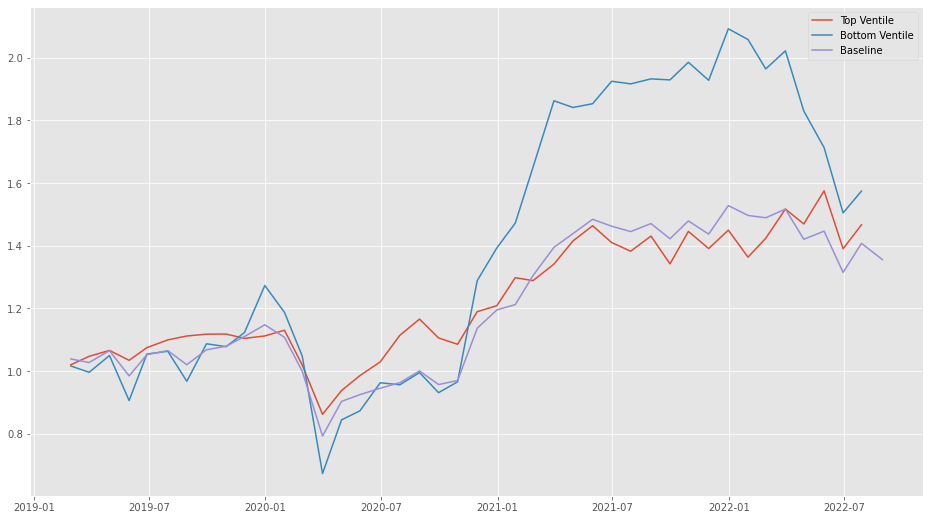

In [61]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16,9))

ax.plot((1+port_rets_monthly[mask_best].mean(axis=1)).cumprod(),label="Top Ventile")
ax.plot((1+port_rets_monthly[mask_worst].mean(axis=1)).cumprod(),label="Bottom Ventile")
ax.plot((1+port_rets_monthly["2019-2-28":].mean(axis=1)).cumprod(), label ="Baseline")

plt.legend()

In [62]:
mask_best.shape[0]

43

#### 4.1 Random Construction

In [83]:
# Random Guess OOS
NSTOCKS  = 469
data = np.array([np.random.permutation(range(1,NSTOCKS+1)) for i in range(mask_best.shape[0])])
data

array([[ 70, 180, 453, ..., 143, 141, 294],
       [ 26, 439,  18, ..., 384,  41, 389],
       [145,  87, 373, ..., 282,  34, 447],
       ...,
       [121, 135, 296, ..., 409, 416, 422],
       [221,  68, 310, ...,   5, 450, 369],
       [355, 368, 244, ..., 461, 412, 295]])

In [84]:
random_guess = pd.DataFrame(
    data,
    columns=mask_best.columns
)

In [85]:
random_guess.index=mask_best.index
random_relevances = random_guess.apply(pd.cut, bins=20, labels=False,axis=1)

In [86]:
random_relevances

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,2,7,19,15,9,17,15,18,7,18,...,6,15,3,11,10,6,6,6,5,12
2019-02-28,1,18,0,19,2,19,12,10,7,8,...,14,13,19,0,2,6,7,16,1,16
2019-03-29,6,3,15,6,3,2,18,14,5,6,...,19,8,14,5,2,1,8,12,1,19
2019-04-30,16,12,12,12,8,7,2,13,7,1,...,5,8,15,6,18,8,16,15,5,18
2019-05-31,17,12,3,11,11,14,7,15,9,0,...,10,12,5,8,13,8,5,12,19,6
2019-06-28,13,0,15,15,19,19,15,11,10,17,...,13,14,5,16,8,15,0,13,6,10
2019-07-31,0,5,8,5,9,18,16,3,9,11,...,11,14,3,2,12,19,0,19,3,13
2019-08-30,3,19,8,4,10,14,12,0,10,6,...,16,13,11,8,15,10,10,5,15,16
2019-09-30,8,7,12,17,16,19,12,14,1,15,...,19,11,0,2,8,19,4,16,7,16


In [87]:
rnd_mask_best = (random_relevances==19).shift(1)
rnd_mask_worst = (random_relevances==0).shift(1)

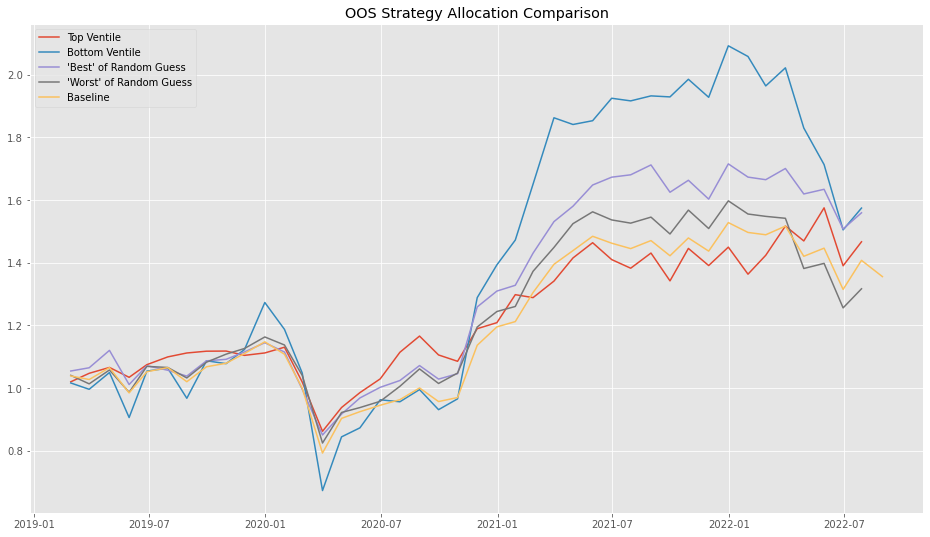

In [89]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16,9))

# LGBMRanker Predictions (non-tuned). Train-Test Split (75%,25%)
ax.plot((1+port_rets_monthly[mask_best].mean(axis=1)).cumprod(),label="Top Ventile")
ax.plot((1+port_rets_monthly[mask_worst].mean(axis=1)).cumprod(),label="Bottom Ventile")

# Random Relevances
ax.plot((1+port_rets_monthly[rnd_mask_best].mean(axis=1)).cumprod(),label="'Best' of Random Guess")
ax.plot((1+port_rets_monthly[rnd_mask_worst].mean(axis=1)).cumprod(),label="'Worst' of Random Guess")

# Equally-Weighted Target Portfolio
ax.plot((1+port_rets_monthly["2019-2-28":].mean(axis=1)).cumprod(), label ="Baseline")

plt.title("OOS Strategy Allocation Comparison")
plt.legend();

In [90]:
%whos DataFrame

Variable                  Type         Data/Info
------------------------------------------------
X_test                    DataFrame             RRET3M    RRET6M<...>[20167 rows x 10 columns]
X_train                   DataFrame             RRET3M    RRET6M<...>[63315 rows x 10 columns]
df                        DataFrame                Date symbols <...>[83482 rows x 13 columns]
mask_best                 DataFrame    symbols         A     AA <...>\n[43 rows x 469 columns]
mask_worst                DataFrame    symbols         A     AA <...>\n[43 rows x 469 columns]
port_rets_monthly         DataFrame                       A     <...>n[191 rows x 469 columns]
predictions               DataFrame                Date symbols <...>n[20167 rows x 3 columns]
random_guess              DataFrame    symbols       A   AA  AAP<...>\n[43 rows x 469 columns]
random_relevances         DataFrame    symbols      A  AA  AAPL <...>\n[43 rows x 469 columns]
rnd_mask_best             DataFrame    symbols 

#### 4.2 Oracle Construction (Perfecte Knowledge of the Future ISharpe Ratio)

In [96]:
oracle_allocation = pd.pivot(
    test[["Date","symbols","relevance"]],
    index="Date",
    columns="symbols",
    values="relevance"
)

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,14,0,8,4,18,16,14,14,9,18,...,15,2,19,12,1,11,10,16,11,6
2019-02-28,15,0,12,7,18,17,14,14,9,19,...,15,2,18,13,9,14,8,17,15,4
2019-03-29,13,0,11,3,18,18,15,16,10,18,...,15,1,18,11,9,14,14,19,10,4
2019-04-30,13,0,9,9,17,16,13,11,8,17,...,4,1,19,8,16,15,16,18,11,4
2019-05-31,15,0,12,9,19,17,14,15,6,17,...,2,2,19,7,16,18,16,19,11,6
2019-06-28,12,0,11,12,19,16,14,16,4,18,...,2,3,19,7,13,16,12,19,12,4
2019-07-31,13,0,9,9,18,13,13,14,5,16,...,2,5,19,8,18,13,16,19,15,4
2019-08-30,12,0,10,7,15,13,11,16,4,12,...,2,8,19,5,18,13,17,18,12,5
2019-09-30,12,0,14,6,15,14,12,14,4,14,...,2,11,19,3,19,13,17,15,14,7


In [97]:
top_crystal_ball = (oracle_allocation==19).shift(1)

In [98]:
top_crystal_ball

symbols,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-03-29,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2019-04-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2019-05-31,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-06-28,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-07-31,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-08-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2019-09-30,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


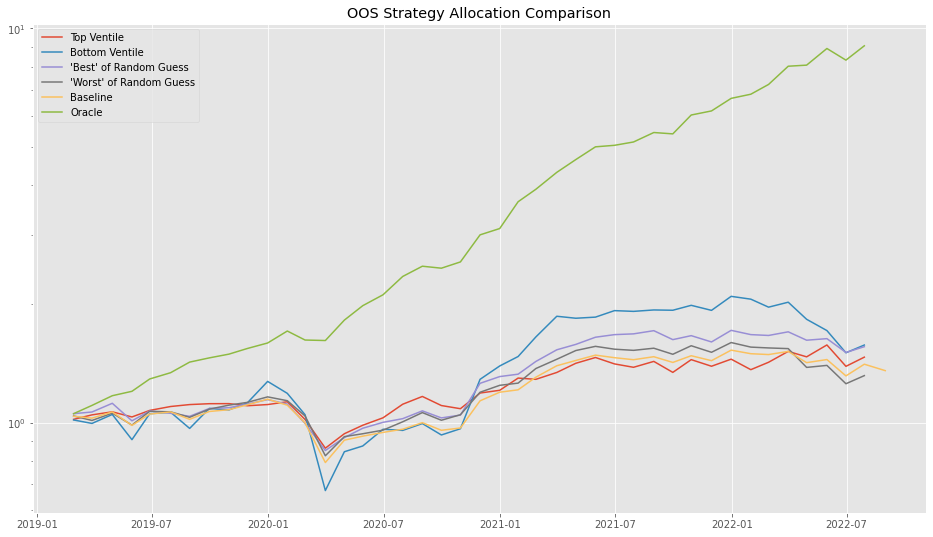

In [100]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(16,9))

# LGBMRanker Predictions (non-tuned). Train-Test Split (75%,25%)
ax.plot((1+port_rets_monthly[mask_best].mean(axis=1)).cumprod(),label="Top Ventile")
ax.plot((1+port_rets_monthly[mask_worst].mean(axis=1)).cumprod(),label="Bottom Ventile")

# Random Relevances
ax.plot((1+port_rets_monthly[rnd_mask_best].mean(axis=1)).cumprod(),label="'Best' of Random Guess")
ax.plot((1+port_rets_monthly[rnd_mask_worst].mean(axis=1)).cumprod(),label="'Worst' of Random Guess")

# Equally-Weighted Target Portfolio
ax.plot((1+port_rets_monthly["2019-2-28":].mean(axis=1)).cumprod(), label ="Baseline")

# Oracle Allocations (100% succesfully ranking)
ax.plot((1+port_rets_monthly[top_crystal_ball].mean(axis=1)).cumprod(), label ="Oracle")

plt.title("OOS Strategy Allocation Comparison")
plt.legend()
plt.semilogy();

**Some Concluding Remarks**:

1. Non-Tuned `LGMBRanker` pairwise ranker does not provide a userful ranking: there's a big difference with the `Oracle` strategy.
2. `Random` Strategies are not significantly different from the ranked ones.
3. Moreover, it seems that if we choose worst predicted performers we tend to outperform top predicted performers. This is a nonsensical outcome and it could be signaling of bad ranking predictions.
4. In sum, it is not clear that this base portfolio could be outperformed by letor-based stock picking for the futures, stocks and train-test set considered.

In [128]:
def stock_alloc(mask):    
    
    stock_picking_timeseries={}

    for i, d in enumerate(mask_best.index):
        try:
            stock_chosen = mask_best.columns[mask.iloc[i]].tolist()
        except:
            stock_chosen = []        
        d = d.strftime("%Y-%m-%d")
        stock_picking_timeseries[d] = stock_chosen 
        
    return pd.DataFrame.from_dict(stock_picking_timeseries, orient="index")

In [129]:
oracle_stocks_picked = stock_alloc(top_crystal_ball)

In [132]:
lgbmranker_stocks_picked = stock_alloc(mask_best)

In [143]:
def accuracy_alloc(oracle, model):
    
    size_port = len(oracle.columns)
    tp_lst = []
    
    for i, _ in enumerate(oracle.index):
        tp_lst.append(
            len(
                set(model.iloc[i]
            ).intersection(oracle.iloc[i])))
    
    hits = pd.DataFrame(tp_lst, index=oracle.index, columns=["hits"])
    hits["prcnt"] = 100*hits["hits"]/size_port
    
    return hits

In [150]:
random_stocks_picked = stock_alloc(rnd_mask_best)
random_stocks_picked

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2019-01-31,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2019-02-28,AAPL,ALE,ANGO,BDX,BOH,CAKE,CIR,CMCSA,DCI,EFX,...,HSIC,MCS,MMC,NSC,NYT,PDCO,PG,STBA,STRA,USM
2019-03-29,ABC,ACIW,AVY,BBY,CPSI,CRS,CXW,ESGR,FBP,HSY,...,OI,OXY,PEG,PFG,SYK,TBI,THS,TMO,TRV,XEL
2019-04-30,AVA,BDX,CMI,COF,CVS,EA,EL,F,FSP,INTC,...,PACW,PDCO,PEP,PGR,UBA,UMPQ,USM,VFC,WWW,ZION
2019-05-31,APD,BOKF,CMA,CSX,CTO,DCOM,DVN,HCSG,INTC,IPG,...,SBUX,SEIC,SLG,TAP,TBI,TFC,UIS,VTRS,WAFD,WMK
2019-06-28,BPOP,CYH,DOV,EBAY,EFX,EMN,FCF,HAFC,HIW,HSII,...,OMC,PHM,PNM,SBCF,STBA,UBA,UPS,UTI,VSH,ZBH
2019-07-31,ABT,ACIW,AVY,BDX,CPF,EXC,FSP,GPC,GVA,HAFC,...,IFF,PCG,PGR,STZ,TER,TGT,TRST,TSN,VLO,WMB
2019-08-30,BAX,BUSE,CAG,CB,CIR,CMS,FE,GD,GWW,HUM,...,ORCL,PAYX,PEP,RAD,RF,SBUX,SWX,UFCS,XRX,YUM
2019-09-30,AA,CI,CMA,CPB,CTBI,CUZ,HES,INTC,LUV,M,...,OGE,PFE,PRU,RGP,SRE,STZ,TJX,TRMK,UGI,WMK
2019-10-31,ACIW,APA,APD,CFFN,CMA,COP,CRS,EL,GILD,HIW,...,PKI,PNW,PPL,SCHW,SCS,TBI,UNP,UVV,WWW,XRX


In [151]:
hits_random = accuracy_alloc(oracle_stocks_picked, random_stocks_picked)

In [153]:
hits_random

,hits,prcnt
2019-01-31,1,4.166667
2019-02-28,1,4.166667
2019-03-29,2,8.333333
2019-04-30,1,4.166667
2019-05-31,1,4.166667
2019-06-28,0,0.000000
2019-07-31,2,8.333333
2019-08-30,3,12.500000
2019-09-30,1,4.166667
2019-10-31,0,0.000000


In [160]:
hits_lgbmranker = hits_lgbmranker.iloc[1:]
hits_oracle = hits_oracle.iloc[1:]
hits_random = hits_random.iloc[1:]

<AxesSubplot:title={'center':'Prcnt of Guessed Relevant Stocks'}>

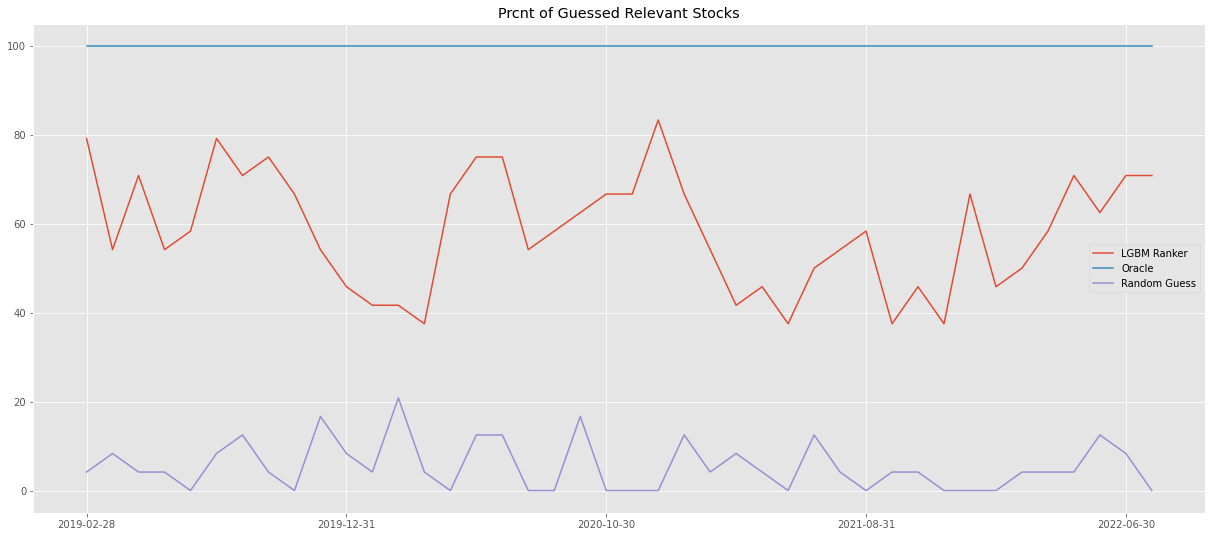

In [161]:
hits_lgbmranker["prcnt"].rename("LGBM Ranker").plot(figsize=(21,9), legend=True, title="Prcnt of Guessed Relevant Stocks")
hits_oracle["prcnt"].rename("Oracle").plot(legend=True)
hits_random["prcnt"].rename("Random Guess").plot(legend=True)